# Imports

In [1]:
import sys
sys.path.append('..')

from src.utils import preprocess_text, count_entity_types
import pandas as pd
import os
import re
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import spacy
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from gensim import corpora
from gensim.models.ldamodel import LdaModel

# Get the Data

In [2]:
data_directory = '../data/raw/'
transcript_files = glob.glob(os.path.join(data_directory, '*_transcripts.json'))

all_transcripts = []

# read all the files in the directory
for file in transcript_files:
    transcript_df = pd.read_json(file)
    all_transcripts.append(transcript_df)
# combine into one df
combined_transcripts_df = pd.concat(all_transcripts, ignore_index=True)
combined_transcripts_df.head()

,symbol,quarter,year,date,content
0,AAL,3,2023,2023-10-19 12:37:10,Operator: Thank you for standing by and welcom...
1,AAL,2,2023,2023-07-20 11:51:04,"Operator: Thank you for standing by, and welco..."
2,AAL,1,2023,2023-04-27 11:15:04,"Operator: Thank you for standing by, and welco..."
3,AAL,4,2022,2023-01-26 12:53:07,"Operator: Thank you for standing by, and welco..."
4,AAL,3,2022,2022-10-20 14:26:04,"Operator: Thank you for standing by, and welco..."


# Process Text

Doing basic pre-processing by using lower case, removing punction, tokenizing and lemmatizing and lastly removing stopwords.

In [3]:
combined_transcripts_df['cleaned_content'] = combined_transcripts_df['content'].apply(preprocess_text)

In [4]:
combined_transcripts_df.head()

,symbol,quarter,year,date,content,cleaned_content
0,AAL,3,2023,2023-10-19 12:37:10,Operator: Thank you for standing by and welcom...,operator thank standing welcome american airli...
1,AAL,2,2023,2023-07-20 11:51:04,"Operator: Thank you for standing by, and welco...",operator thank standing welcome american airli...
2,AAL,1,2023,2023-04-27 11:15:04,"Operator: Thank you for standing by, and welco...",operator thank standing welcome american airli...
3,AAL,4,2022,2023-01-26 12:53:07,"Operator: Thank you for standing by, and welco...",operator thank standing welcome american airli...
4,AAL,3,2022,2022-10-20 14:26:04,"Operator: Thank you for standing by, and welco...",operator thank standing welcome american airli...


Adding polarity and subjectivity columns, based on the sentiment. The sentiment column created using TextBlob is a tuple with the polarity and subjectivity scores. I kept the sentiment column in as a reference.

In [5]:
combined_transcripts_df['sentiment'] = combined_transcripts_df['cleaned_content'].apply(lambda text: TextBlob(text).sentiment)
combined_transcripts_df['polarity'] = combined_transcripts_df['sentiment'].apply(lambda x: x.polarity)
combined_transcripts_df['subjectivity'] = combined_transcripts_df['sentiment'].apply(lambda x: x.subjectivity)

In [6]:
combined_transcripts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   symbol           297 non-null    object        
 1   quarter          297 non-null    int64         
 2   year             297 non-null    int64         
 3   date             297 non-null    datetime64[ns]
 4   content          297 non-null    object        
 5   cleaned_content  297 non-null    object        
 6   sentiment        297 non-null    object        
 7   polarity         297 non-null    float64       
 8   subjectivity     297 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 21.0+ KB


# Visualizations

## Polarity

Polarity gauges the emotional direction of the text and ranges from -1 (negative emotions like anger or sadness) to +1 (positive emotions such as happiness or joy), with 0 representing neutrality. While evaulating earning call transcripts, it would be desirable to understand the emotional leaning of a particular earnings call to understand if there is any connection with the companies performance that could lead to an increase of the stock price. At the industry level, there could be value determing the direction of the industry based on the earnings calls.

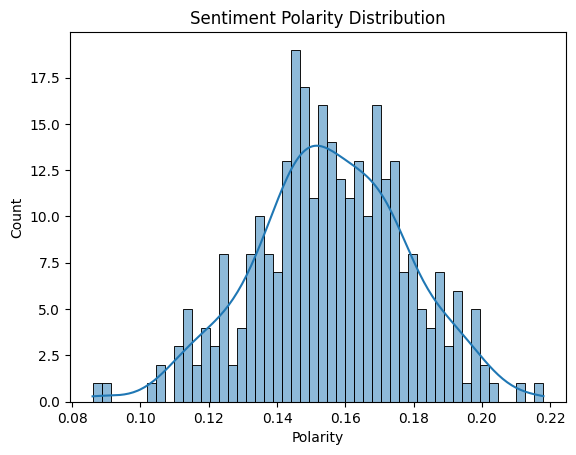

In [7]:
# looking at aggregate polarity distribution
sns.histplot(combined_transcripts_df['polarity'], bins = 50, kde = True)
plt.title('Sentiment Polarity Distribution')
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.show()

The chart shown below shows the polarity of each quarter for the airline industry. The boxplot shows the range of values for the group and any outliers. The polarity scores seem to show neutrality to slightly positive. This can be expected given that we have done very light pre-processing of the text and have kept many of the filler words that are common from call to call, including the formalities. For the sake of this analysis, I will keep these in to create a basis to compare for future analyses. Reducing expected noise in future evaluations will help give a more accurate account of emotional direction of earnings calls. Keep in mind, however that calls tend to lean positive even given negative company performance due to management incentive to prevent anything negatively affecting the stock price. 

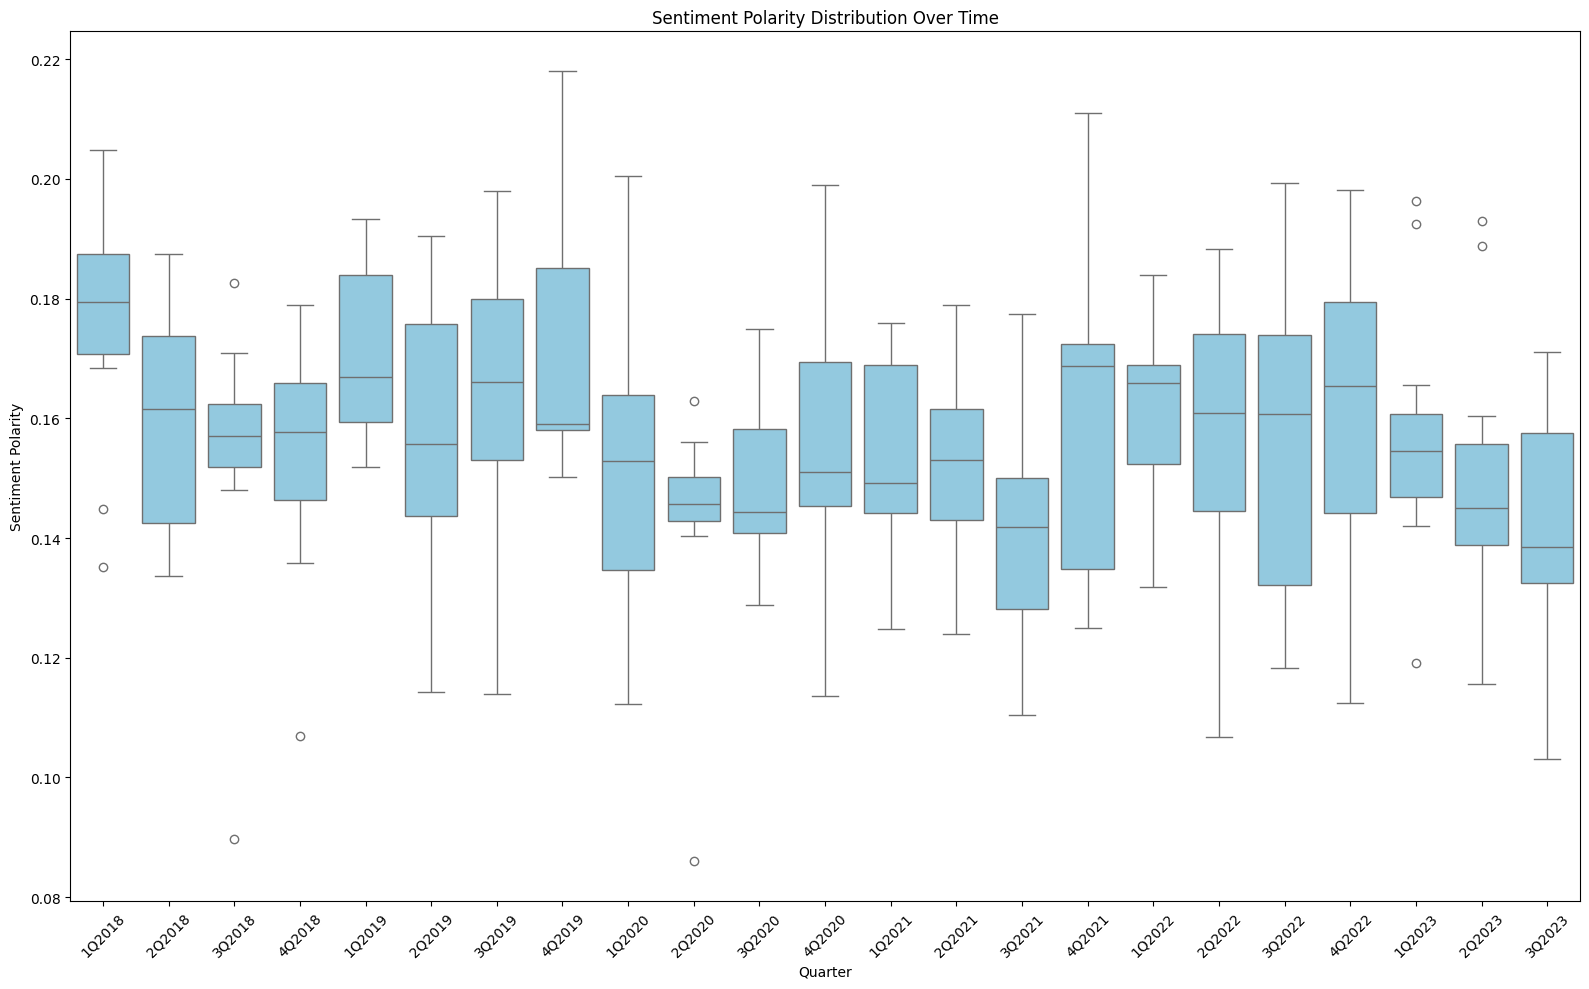

In [8]:
# Creating a quarter-year column
combined_transcripts_df['quarter_year'] = combined_transcripts_df['quarter'].astype(str) + 'Q' + combined_transcripts_df['year'].astype(str)
combined_transcripts_df.sort_values(by='date', ascending = True, inplace = True)

plt.figure(figsize=(16, 10))
sns.boxplot(data=combined_transcripts_df, x='quarter_year', y='polarity', color='skyblue')
plt.title('Sentiment Polarity Distribution Over Time')
plt.xlabel('Quarter')
plt.ylabel('Sentiment Polarity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Here looking at polarity separately for each ticker. There are slight downtrends for several tickers, but since the axis is fairly granular, these changes are not large.

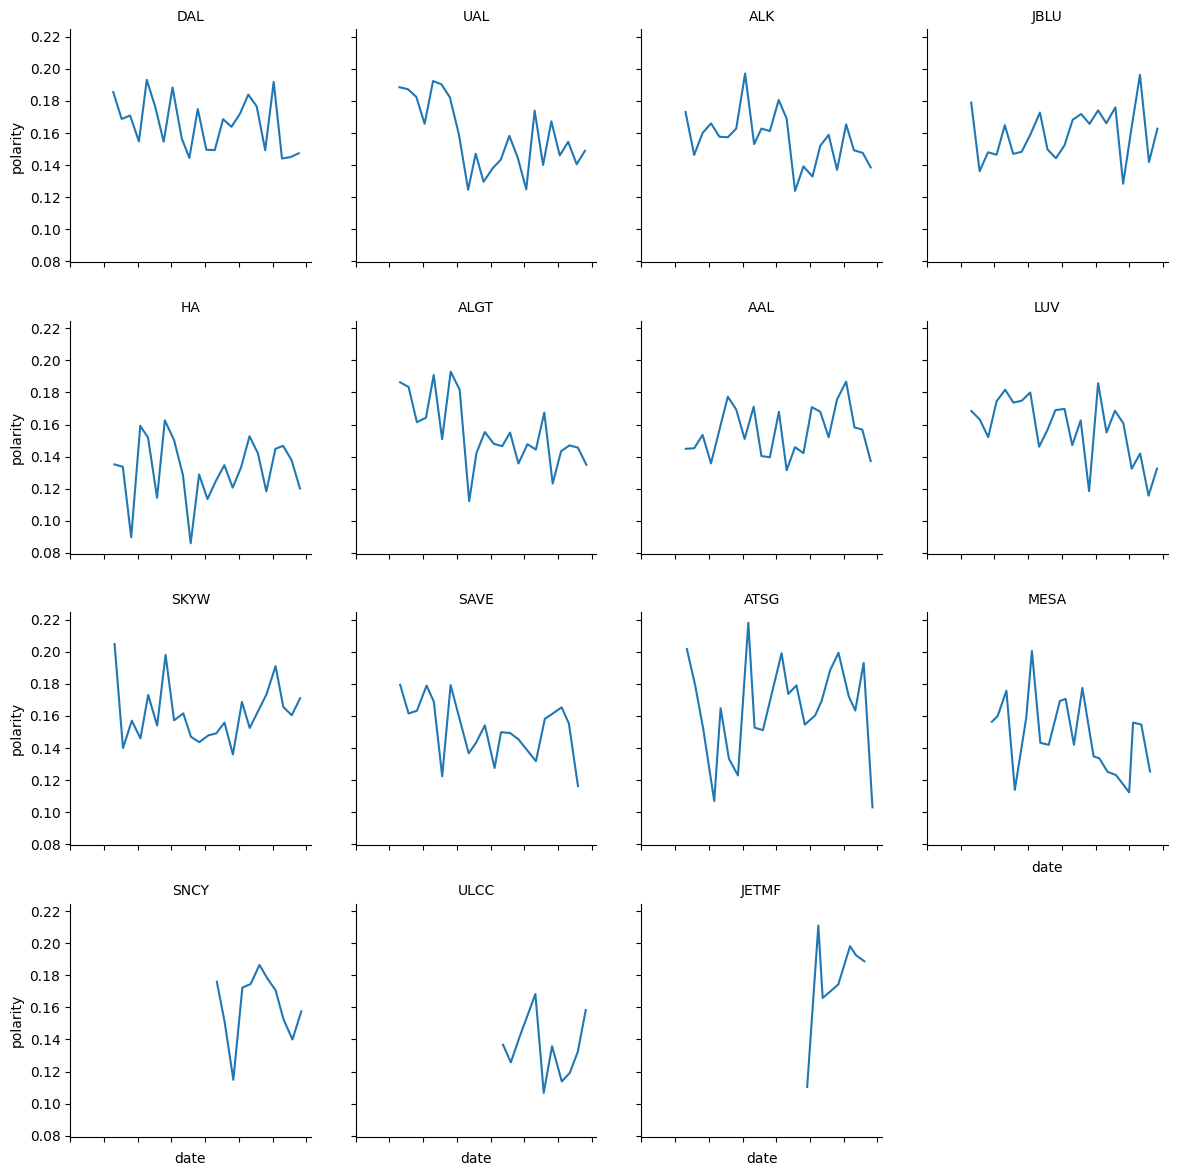

In [9]:
# creating a grid to look at each ticker
g = sns.FacetGrid(combined_transcripts_df, col="symbol", col_wrap=4, height=3, sharey=True)
g = g.map(plt.plot, "date", "polarity")
g.set_titles("{col_name}")
g.set_xticklabels(rotation=45)
plt.show()

The heatmap also shows a slight decrease over time across the group of tickers, though very slight.

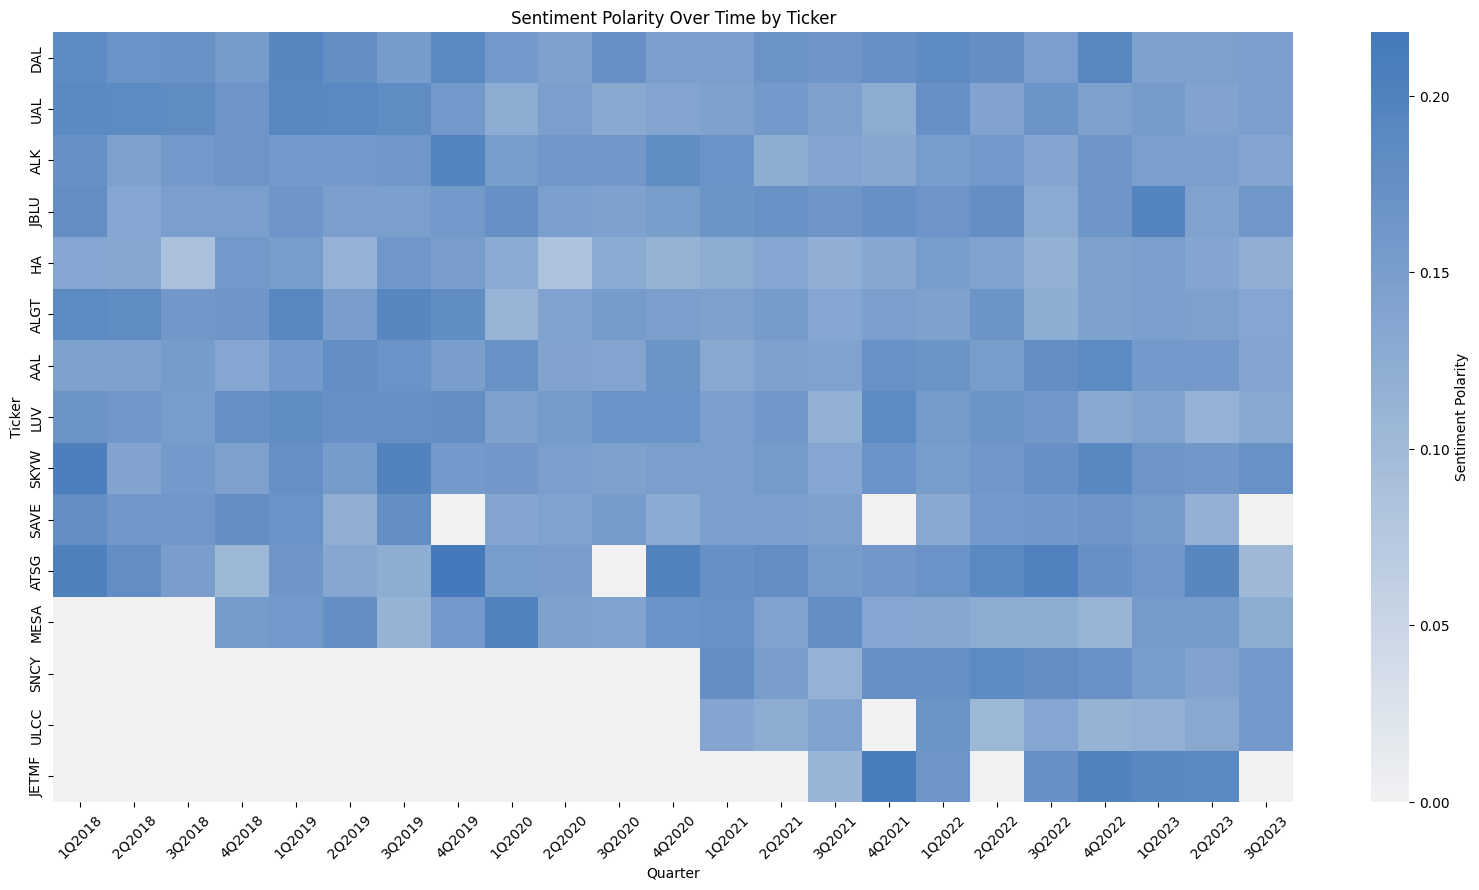

In [10]:
# Using sentiment polarity scores to create a heatmap over time
heatmap_data = combined_transcripts_df.pivot_table(index='symbol', columns='quarter_year', values='polarity', fill_value=0, sort = False)
cmap = sns.diverging_palette(240, 250, n=9, center="light", as_cmap=True)
plt.figure(figsize=(20, 10))
sns.heatmap(heatmap_data, cmap=cmap, center=0, cbar_kws={'label': 'Sentiment Polarity', 'ticks': np.arange(0, max(heatmap_data.max().max(), 0.25), 0.05)})
plt.title('Sentiment Polarity Over Time by Ticker')
plt.xlabel('Quarter')
plt.ylabel('Ticker')
plt.xticks(rotation=45)
plt.show()

## Subjectivity

Subjectivity measures the amount of opinions (higher score) and facts (lower score) are in a text. Words such as "I believe", "the best", "in my opinion" can indicate possible subjectivity.

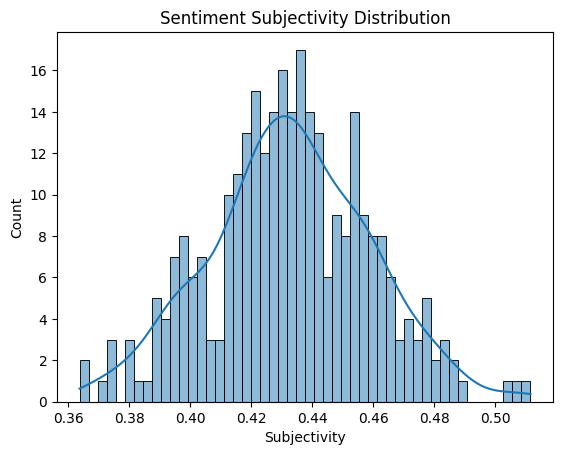

In [11]:
# looking at aggregate subjectivity distribution
sns.histplot(combined_transcripts_df['subjectivity'], bins = 50, kde = True)
plt.title('Sentiment Subjectivity Distribution')
plt.xlabel('Subjectivity')
plt.ylabel('Count')
plt.show()

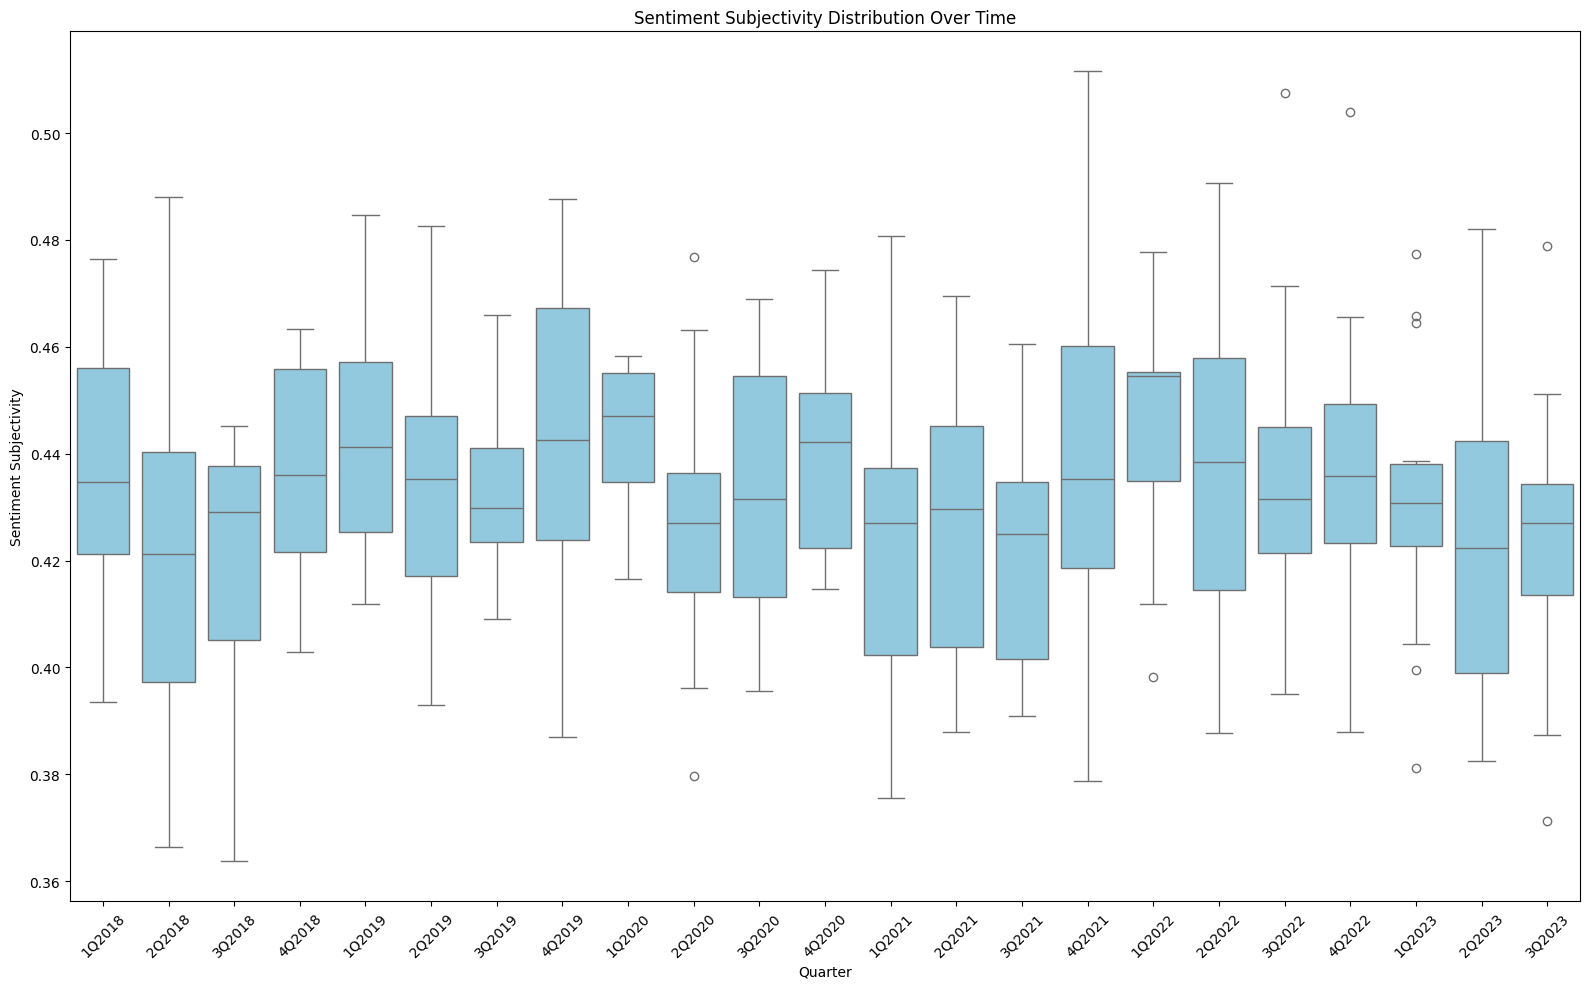

In [12]:
# We'll use the same charts for subjectivity that we did with polarity
plt.figure(figsize=(16, 10))
sns.boxplot(data=combined_transcripts_df, x='quarter_year', y='subjectivity', color='skyblue')
plt.title('Sentiment Subjectivity Distribution Over Time')
plt.xlabel('Quarter')
plt.ylabel('Sentiment Subjectivity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Similar to polarity, the grid below shows that subjectivity has a very slight downward tilt, with a few exceptions, though overall the changes are very minimal.

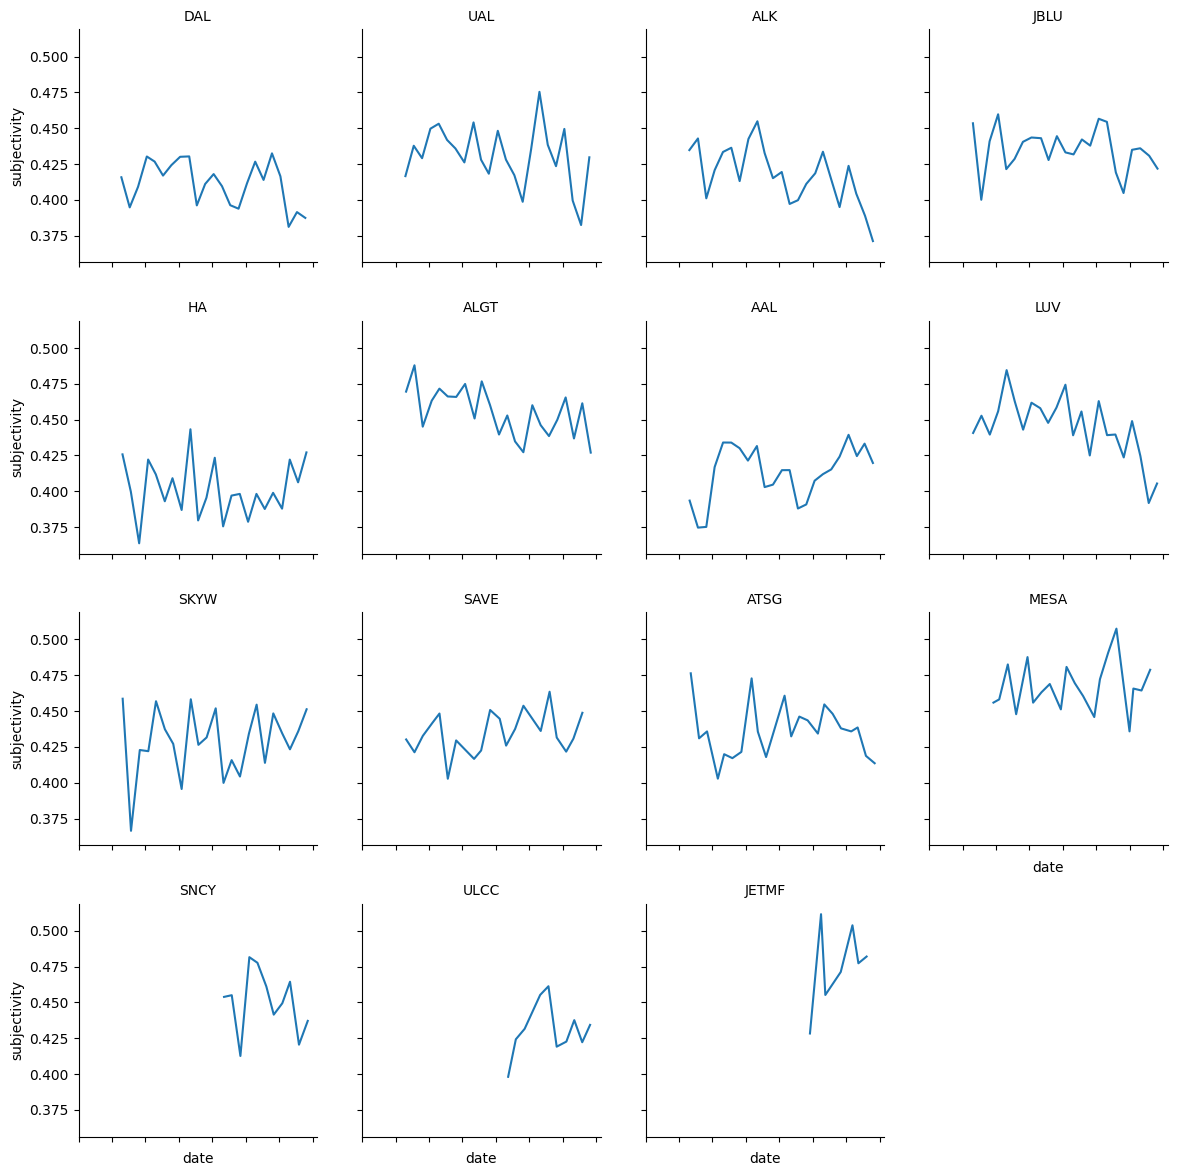

In [13]:
# here's the grid looking at each ticker
g = sns.FacetGrid(combined_transcripts_df, col="symbol", col_wrap=4, height=3, sharey=True)
g = g.map(plt.plot, "date", "subjectivity")
g.set_titles("{col_name}")
g.set_xticklabels(rotation=45)
plt.show()

The heatmap also shows the slight change over time, though a little more difficult to see compared to the polarity heatmap

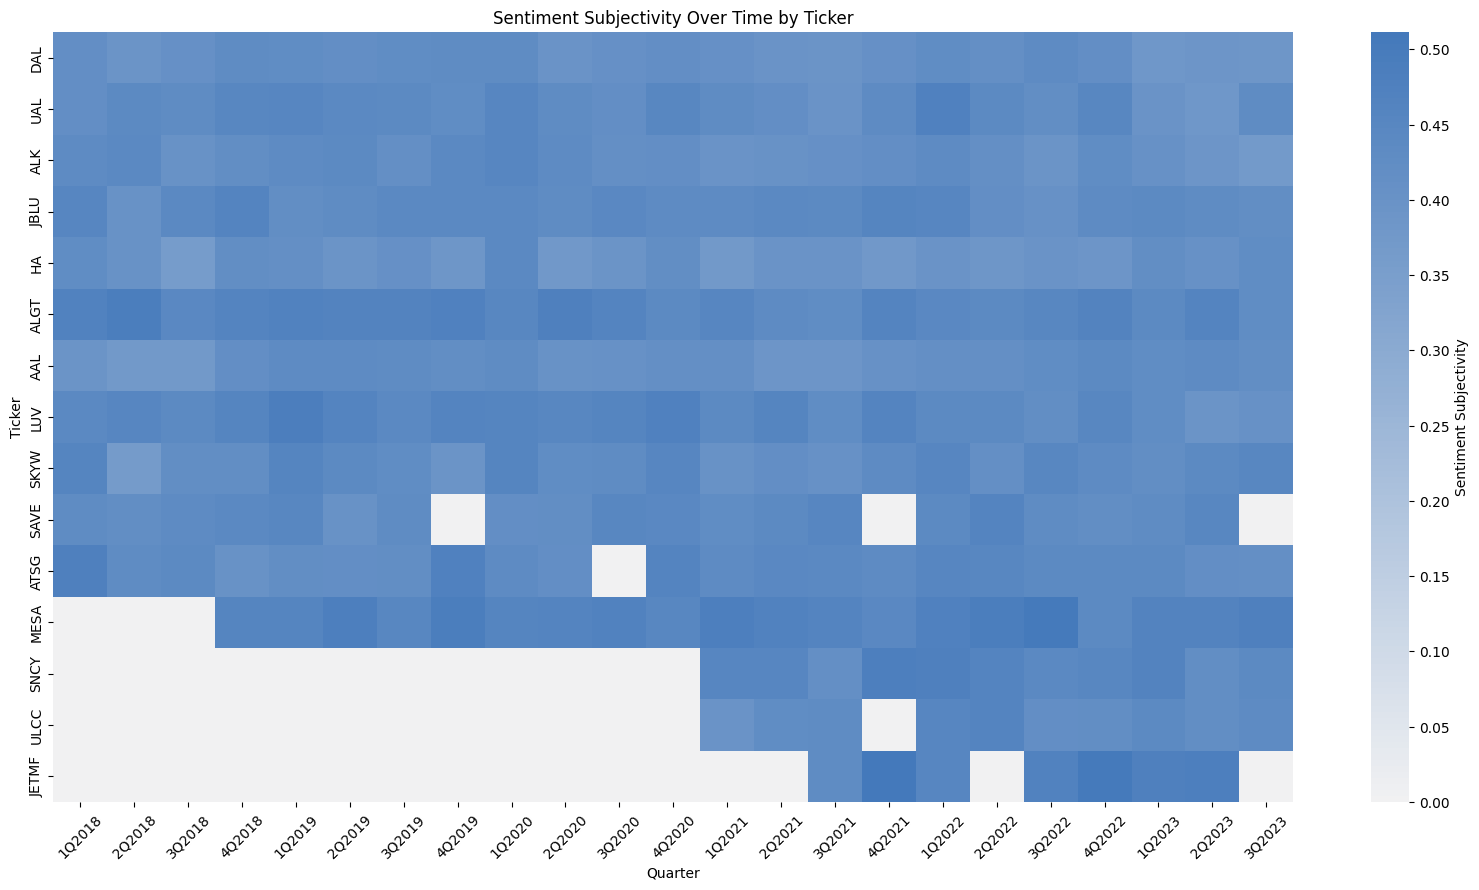

In [14]:
# Using sentiment subjectivity scores to create a heatmap over time
heatmap_data = combined_transcripts_df.pivot_table(index='symbol', columns='quarter_year', values='subjectivity', fill_value=0, sort = False)
cmap = sns.diverging_palette(240, 250, n=9, center="light", as_cmap=True)
plt.figure(figsize=(20, 10))
sns.heatmap(heatmap_data, cmap=cmap, center=0, cbar_kws={'label': 'Sentiment Subjectivity', 'ticks': np.arange(0, max(heatmap_data.max().max(), 0.25), 0.05)})
plt.title('Sentiment Subjectivity Over Time by Ticker')
plt.xlabel('Quarter')
plt.ylabel('Ticker')
plt.xticks(rotation=45)
plt.show()

## Topics

We will use the Latent Dirichlet Allocation (LDA) model here to look at what topics exist in the text. Looking at the output topics, it's apparent that more pre-processing will need to be done with our text in order to get more meaningful insights here. Most of the words present are very general and can be dropped in future processing. There are also some punctation that is present that will need to be dropped as well. It also would be more helpful to look at each company and each quarter separately instead of an aggregated view like this, but knowing that our processing would need to be more robust anyways, I have kept this in here to get an idea of what the texts look like as well as a sort of baseline. This can even be a separate analysis down the road when we have a better pre-processing method to handle these transcripts.

In [15]:
texts = [[word for word in word_tokenize(document)]
         for document in combined_transcripts_df['cleaned_content']]

# create a dictionary representation of the documents
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, random_state=100, update_every=1, passes=10, alpha=1, eta=.01)
topics = lda_model.print_topics(num_words=5)

# clean up the output and get the words
cleaned_topics = []
for topic_number, topic_words in topics:
    words = re.findall(r'"([^"]*)"', topic_words)
    cleaned_topics.append(words)

for i, topic in enumerate(cleaned_topics):
    print(f"Topic {i}: {topic}")

Topic 0: ['think', 'year', 'quarter', 'well', 'cost']
Topic 1: ['year', 'think', 'quarter', 'well', 'going']
Topic 2: ['think', 'year', 'quarter', 'cost', 'u']
Topic 3: ['’', 'quarter', '–', 'think', 'year']
Topic 4: ['u', 'aircraft', '’', 'year', 'get']
Topic 5: ['think', 'quarter', 'year', 'going', 'question']
Topic 6: ['year', 'aircraft', 'quarter', 'million', 'think']
Topic 7: ['million', 'think', 'quarter', 'aircraft', 'year']
Topic 8: ['quarter', 'year', 'think', 'question', 'going']
Topic 9: ['’', 'year', 'think', 'quarter', 'going']


## Named Entities

In [16]:
# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

# Apply named entity recognition
combined_transcripts_df['named_entities'] = combined_transcripts_df['cleaned_content'].apply(lambda x: [(ent.text, ent.label_) for ent in nlp(x).ents])

# Look at the named entities in the first document
print(combined_transcripts_df['named_entities'].iloc[0])

[('ir ed bastian', 'PERSON'), ('glen hauenstein', 'PERSON'), ('paul jacobson', 'PERSON'), ('john walker', 'PERSON'), ('joseph denardi stifel jamie baker', 'PERSON'), ('jpmorgan', 'ORG'), ('keay wolfe', 'ORG'), ('mike linenberg', 'PERSON'), ('deutsche bank', 'ORG'), ('helane becker', 'PERSON'), ('isi jack', 'PERSON'), ('stephen savi', 'PERSON'), ('raymond james darryl genovesi', 'PERSON'), ('morgan stanley', 'ORG'), ('dan mckenzie', 'PERSON'), ('buckingham', 'GPE'), ('susan donofrio', 'PERSON'), ('macquarie bank alana', 'ORG'), ('michael sasso bloomberg news', 'PERSON'), ('edward russell', 'PERSON'), ('delta air', 'ORG'), ('march quarter 2018', 'DATE'), ('today', 'DATE'), ('march quarter', 'DATE'), ('today', 'DATE'), ('atlanta', 'GPE'), ('ed bastian', 'PERSON'), ('glen hauenstein', 'PERSON'), ('paul jacobson', 'PERSON'), ('one', 'CARDINAL'), ('today', 'DATE'), ('delta sec', 'ORG'), ('january 1', 'DATE'), ('nongaap', 'DATE'), ('ed ed bastian', 'PERSON'), ('earlier today', 'TIME'), ('676 

What I want to do is do a raw count of each entity type and take a look at how those change over time. I'll do an aggregate view here first and then look at each ticker individually. As we have seen in the data so far, we will definitely want to do more data scrubbing here in future analyses, but am intentionally leaving this fairly raw overall to get a baseline view for comparison.

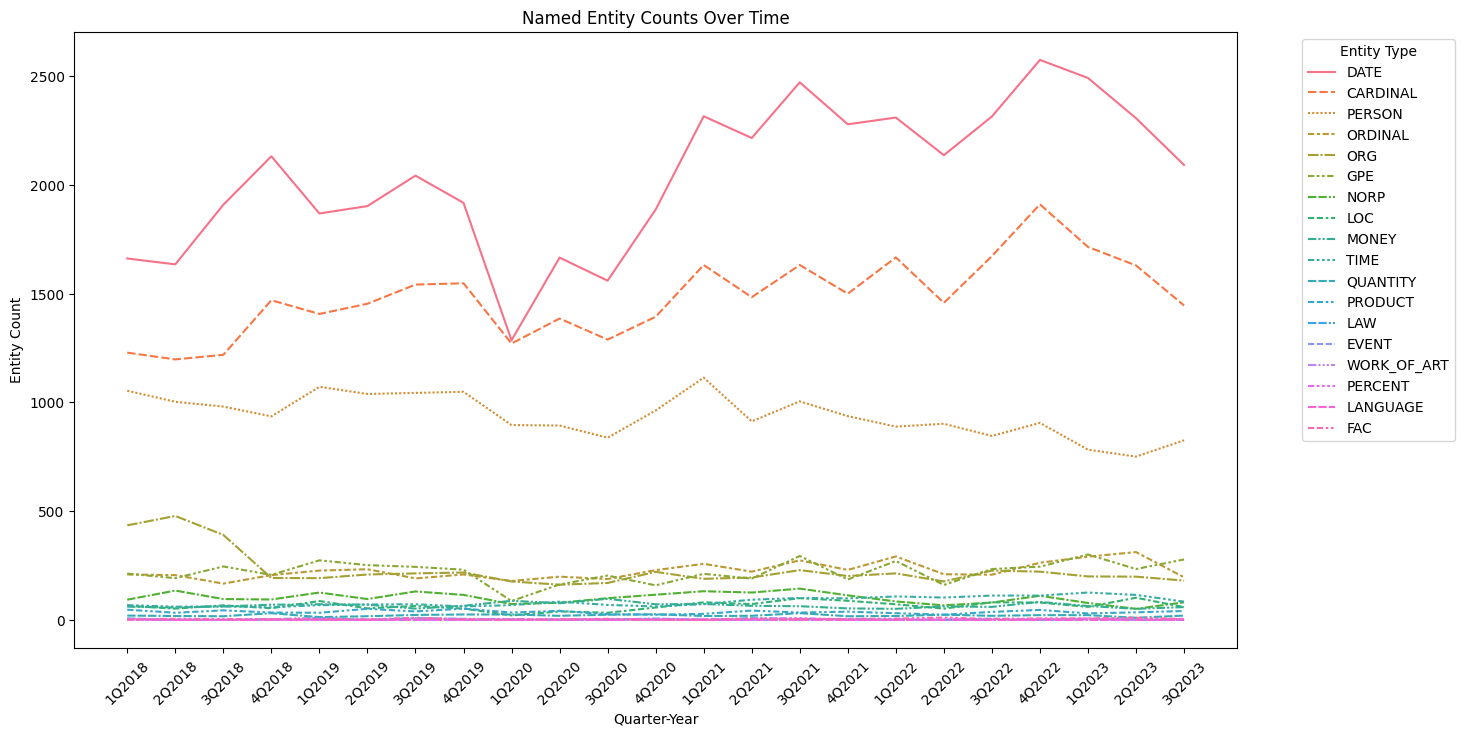

In [17]:
# Aggregate view
# Creating new dataframe with entity type counts
entity_counts_df = combined_transcripts_df['named_entities'].apply(count_entity_types)
entity_counts_df.fillna(0, inplace=True)

# We need to make the quarter_year a categorical to keep ordering in place
entity_counts_df['quarter_year'] = combined_transcripts_df['quarter'].astype(str) + 'Q' + combined_transcripts_df['year'].astype(str)
entity_counts_df['date'] = combined_transcripts_df['date']
entity_counts_df.sort_values(by='date', ascending = True, inplace = True)
entity_counts_df.drop('date', axis = 1, inplace = True)

# making the quarter-year column to be categorical
entity_counts_df['quarter_year'] = pd.Categorical(entity_counts_df['quarter_year'], ordered=True, categories=entity_counts_df['quarter_year'].unique())

# Group by 'quarter_year' and sum the entity counts
grouped_entity_counts = entity_counts_df.groupby('quarter_year', observed = True).sum()

# Plotting
plt.figure(figsize=(15, 8))
sns.lineplot(data=grouped_entity_counts)
plt.title('Named Entity Counts Over Time')
plt.xlabel('Quarter-Year')
plt.ylabel('Entity Count')
plt.xticks(rotation=45)
plt.legend(title='Entity Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

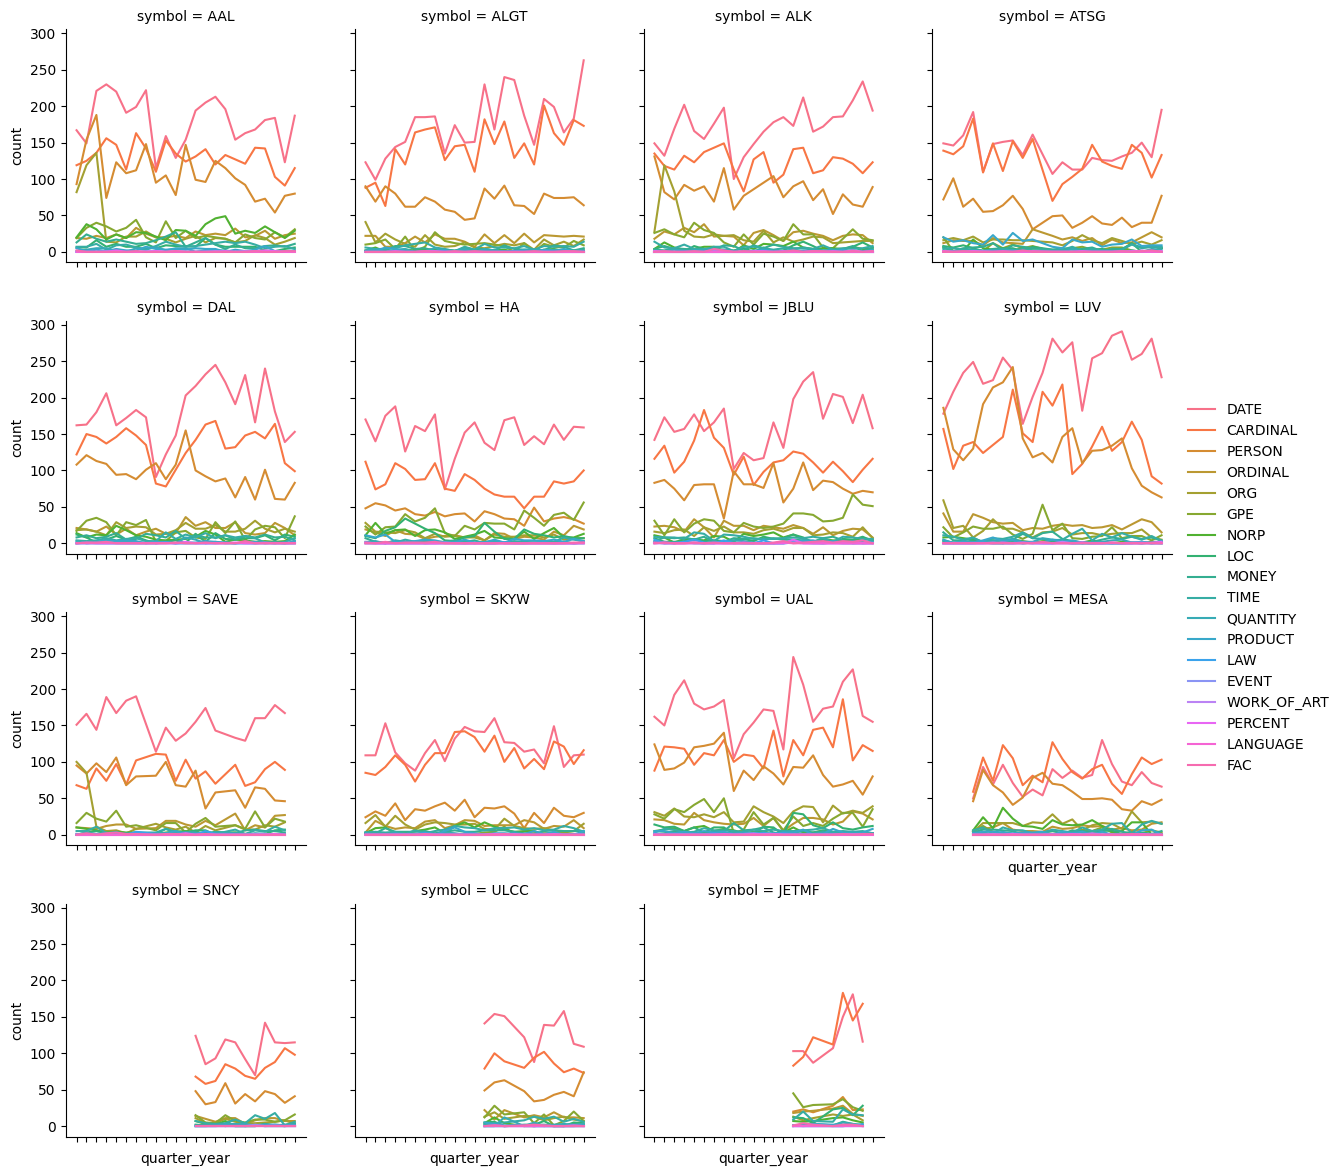

In [22]:
# Individual Ticker View
# Aggregate NER counts for each document and ticker
entity_counts_df['symbol'] = combined_transcripts_df['symbol']
grouped_entity_counts = entity_counts_df.groupby(['quarter_year', 'symbol'], observed = True).sum().reset_index()

# Reshape the dataframe for the facet grid
melted_entity_counts = grouped_entity_counts.melt(id_vars=['quarter_year', 'symbol'], var_name='entity_type', value_name='count')

# Create the grid
g = sns.FacetGrid(melted_entity_counts, col="symbol", col_wrap=4, height=3, sharey=True)
g = g.map(sns.lineplot, "quarter_year", "count", "entity_type")
g.add_legend()
g.set_xticklabels(rotation=45)
plt.show()

# Conclusion

For this notebook, we looked at several different angles of the earning call transcripts. There were some at the aggregate and some at the ticker level. Overall, these show that more processing of the data will be needed and we need to have more robust methods for removing noise and focusing on words and concepts that provide more signal. This notebook and overall project aims to provide a baseline approach for comparison to more robust methods in the future. 